In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import quaternion
import lib

import estimators
import matplotlib.pyplot as plt
from lib.analysis.constants import * # All access constants in here
from lib.analysis import plotting as plot
import pykalman

In [5]:
processed = plot.load_data(path="./data/three_drone_box_fhuman_ground_truth.npz")

In [6]:
print(processed.keys())
print(processed[DRONES[0]].keys())
print(processed[BOX].keys())

dict_keys(['god', 'drone_2', 'drone_3', 'box', 'drone_1'])
dict_keys(['Fd_obs', 'external_force', 'velocity', 'position', 'waypoint', 'control', 'simulator_full_state'])
dict_keys(['position', 'F_human'])


In [7]:
class Drone():
    def __init__(self, data, drone_num):
        pass
    
# TODO: FILL IN CLASS

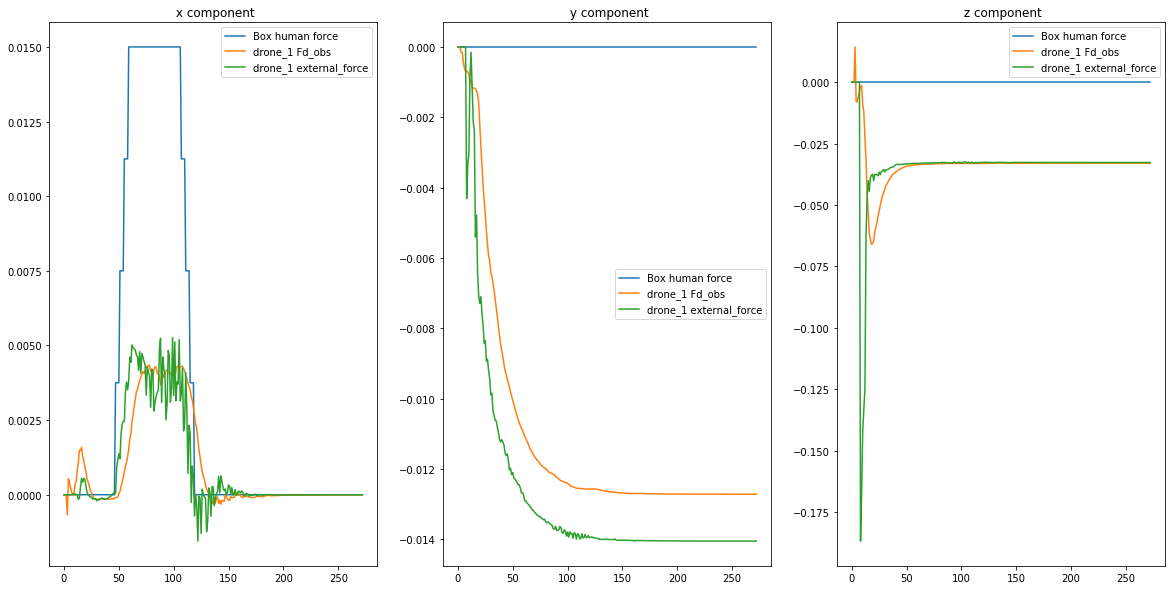

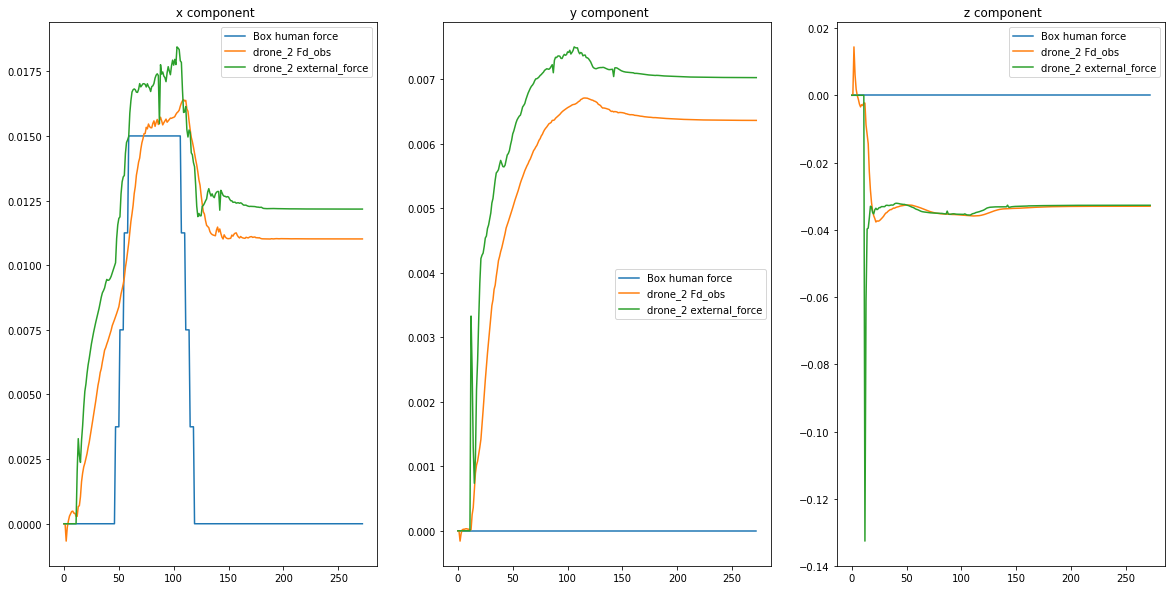

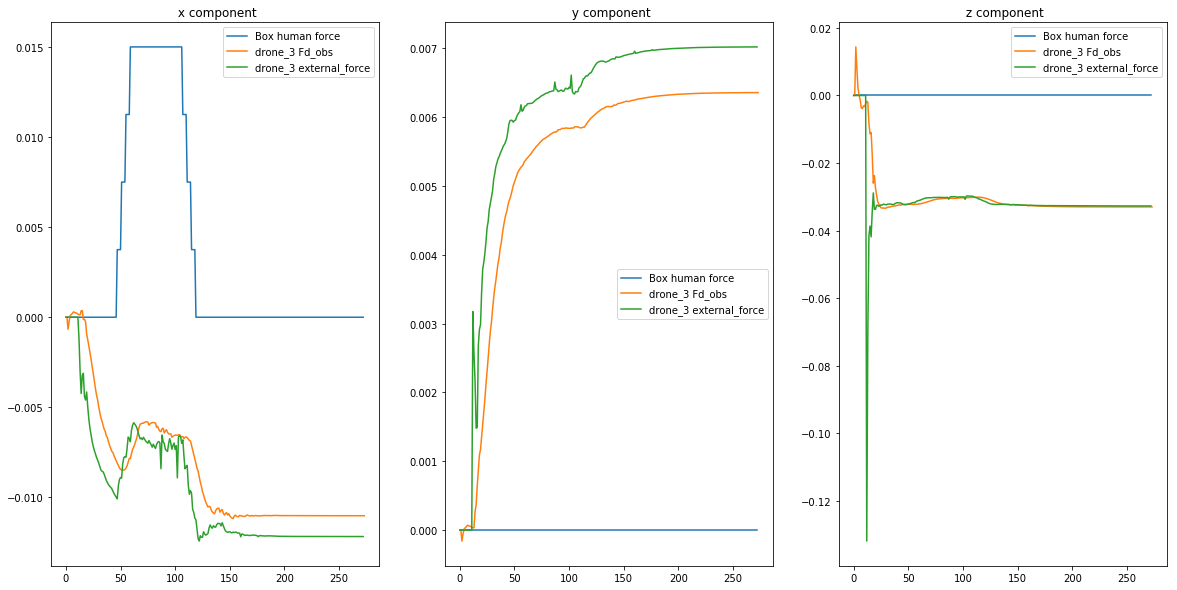

In [8]:
for drone in DRONES:
    forces, names = [processed[BOX][F_HUMAN][:, 1:]], ["Box human force"]
    for name, data in processed.items():
        if name == drone:
    #         forces.append(data[F_HUMAN])
    #         names.append("{} {}".format(name, F_HUMAN))

            forces.append(data[FD_OBS][:, 1:])
            names.append("{} {}".format(name, FD_OBS))

            forces.append(data[EXTERNAL_FORCE][:, 1:])
            names.append("{} {}".format(name, EXTERNAL_FORCE))   
    # for f in forces:
    #     print(f[:, 1])
    plot.plot_vectors(*forces, names=names)



### Estimator Test

In [9]:
curr_drone = DRONES[0]
x_s = processed[curr_drone][SIMULATOR_FULL_STATE][:, 1:]
U = processed[curr_drone][CONTROL][:, 1:]

In [10]:
# get_full_state = lambda drone_num: get_state_as_controller_state(
#     processed[DRONES[drone_num]][POSITION], processed[curr_drone][VELOCITY]
# )
# x_s = get_full_state(0)
def get_full_state(drone_num):
    full_state = processed[DRONES[drone_num]][SIMULATOR_FULL_STATE][:, 1:]
    return np.hstack( (full_state[:, 0:3], full_state[:, 6:9], full_state[:, 3:6], full_state[:, 9:12]) )

# get_full_state = lambda drone_num: 
x_s = get_full_state(0)
x_s2 = get_full_state(1)
x_s3 = get_full_state(2)

In [11]:
x_s.shape

(273, 12)

(<matplotlib.axes._subplots.AxesSubplot at 0x113d30b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114789e10>)

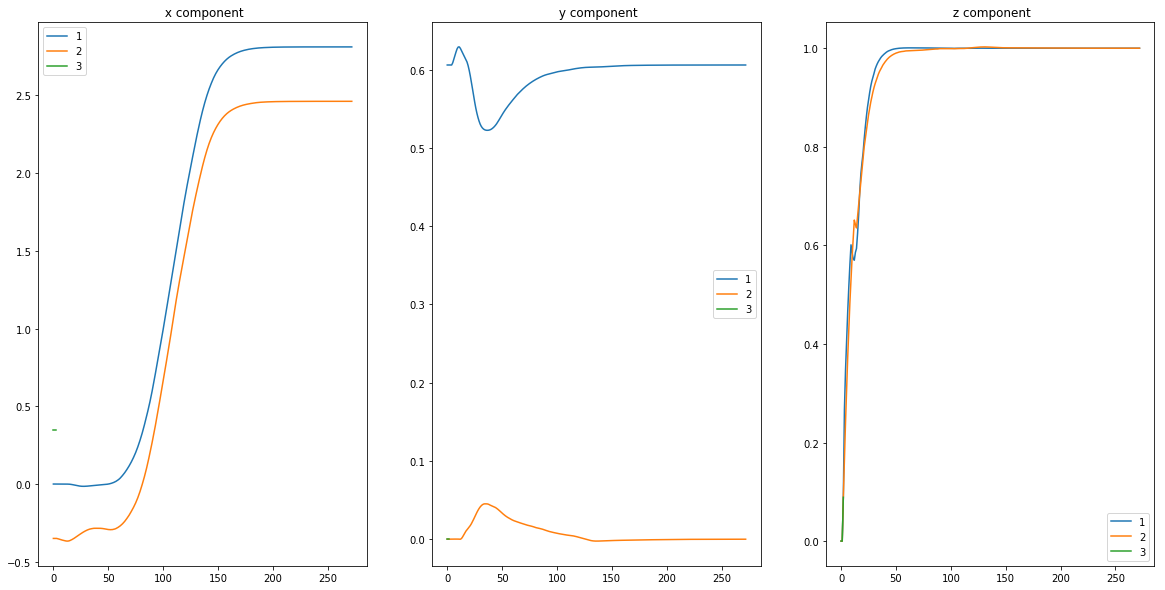

In [12]:
plot.plot_vectors(x_s[:,0:3], x_s2[:, 0:3], x_s3[0:3], names=["1", "2", "3"])

In [13]:
all_x_s = [x_s, x_s2, x_s3]

Bg= np.zeros((12,1))
Bg[5] = -GRAVITY
Bg= T_STEP*Bg.flatten()

Bd = np.zeros((12,3))
Bd[3,0] = T_STEP/M 
Bd[4,1] = T_STEP/M 
Bd[5,2] = T_STEP/M

C = np.eye(12)

x_obs = np.zeros((15,1))

# Remaining constants from constants file

observer = estimators.Linear_Observer(A=A, B=B, Bg=Bg, Bd=Bd, x_init=x_obs, C=C)
for x_s_curr, drone in zip(all_x_s ,DRONES):
    

     

    


    A_obs = np.block([[A,Bd],[np.zeros((3,12)),np.eye(3)]])
    B_obs = np.block([[B],[np.zeros((3,4))]])
    # C = np.block([np.eye(3),np.zeros((3,9))])
    C = np.eye(12)
    Cd = np.zeros((12,3))
    Bg_obs = np.block([[Bg.reshape((12,1))],[np.zeros((3,1))]])
    C_obs = np.block([[C,Cd]])
#     poles = np.array([93.,94,95,96,97,98,99,100,101,102,103,104,105,106,107])/130
#     poles = np.linspace(0, 1, 15)
    poles = np.arange(1, 16) / 130
    sys = scipy.signal.place_poles(A_obs.transpose(),C_obs.transpose(),poles)
    L_obs = sys.gain_matrix.transpose()

    x_obs_vals = []
    for x, u in zip(x_s_curr, U):
#         Fd_obs, state_obs = observer.update_estimate(y=x.reshape((12, 1)), u=u.reshape((4,1)))
#         x_obs_vals.append(np.hstack((Fd_obs, state_obs)))
        x_obs = np.dot(A_obs,x_obs) + \
            np.dot(B_obs,u.reshape((4,1))) + \
            Bg_obs - \
            L_obs.dot(x_obs[0:12] - x.reshape((12,1)))
        x_obs_vals.append(x_obs.flatten())

    x_obs_vals = np.array(x_obs_vals)
    Fd_obs = x_obs_vals[:, 12:]
    Fd_act = processed[drone][EXTERNAL_FORCE][:, 1:]
    Fd_obs_rec = processed[drone][FD_OBS][:, 1:]
    plot.plot_vectors(Fd_obs, Fd_act, Fd_obs_rec,  names=["obs", "act", "obs_rec"])
    plot.plot_vectors(x_s_curr[:, 6:9] * 180 / np.pi, names=["angle"])

TypeError: Can't instantiate abstract class Linear_Observer with abstract methods get_trajectory

In [ ]:
observer.x_est.shape

In [ ]:
x_obs_vals.shape, x_obs.shape, x_s.shape

### Simple Estimator Using a_com

In [ ]:

def est_box_mass_all_drones(drone_num, est_fd=False):
    curr_drone = DRONES[drone_num]
    curr_drone_data = processed[curr_drone]
    if est_fd: Fd_mag = np.linalg.norm(curr_drone_data[FD_OBS][:, 1:4], axis=1)
    else: Fd_mag = np.linalg.norm(curr_drone_data[EXTERNAL_FORCE][:, 1:4], axis=1)
    
    F_z = np.zeros(len(curr_drone_data[POSITION]))
    for d in DRONES:
        F_z += Fd_mag * (processed[d][POSITION][:, 3] - processed[BOX][POSITION][:, 3])
    return F_z / GRAVITY
    

In [ ]:
BOX_MASS = 0.01
for i in range(len(DRONES)):
    est = est_box_mass_all_drones(i)
    plt.plot(est, label=DRONES[i])
plt.plot([BOX_MASS] * len(est), label="True est")
plt.legend()
plt.ylim([0, 0.015])

In [ ]:
def est_force_by_human(box_mass_est):
    F_human = np.zeros((len(processed[DRONES[0]][POSITION]) - 2 , 3))
    for d in DRONES:
        a_d = np.diff(np.diff(processed[d][POSITION][:, 1:4], axis=0), axis=0) / T_STEP**2
        F_human += (M * a_d.T).T
    for d in [BOX]:
        a_d = np.diff(np.diff(processed[d][POSITION][:, 1:4], axis=0), axis=0) / T_STEP**2
        if type(box_mass_est) == float:
            F_human += box_mass_est * a_d
        else:            
            F_human += (box_mass_est[:-2] * a_d.T).T
    return F_human
    

In [ ]:
a_d = np.diff(np.diff(processed[curr_drone][POSITION][:, 1:4], axis=0), axis=0) / T_STEP ** 2
a_d * 0.01

In [ ]:
processed[BOX][F_HUMAN][:, 1:4].shape

In [ ]:
def moving_average(a, n=3, axis=0) :
    ret = np.cumsum(a, dtype=float, axis=axis)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
all_fs = []
for i in range(len(DRONES)):
    est = est_box_mass_all_drones(i)
    F_est = est_force_by_human(0.015)
    print(F_est.shape)
    all_fs.append(moving_average(F_est, n=3))
all_fs.append(processed[BOX][F_HUMAN][2:-2, 1:4])

plot.plot_vectors(*all_fs, names=DRONES + [BOX])
#     plt.plot(est, label=DRONES[i])

### Ground truth all ext forces

In [14]:
forces = [0.] * len(processed[DRONES[0]][POSITION][:, 1:])
for i in range(len(processed[DRONES[0]][POSITION][:, 1:])):
    forces[i] = sum([processed[d][FD_OBS][i, 1:4] for d in DRONES])

In [15]:
forces = np.array(forces)
forces.shape

(273, 3)

(<matplotlib.axes._subplots.AxesSubplot at 0x114c78d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x114ca2518>)

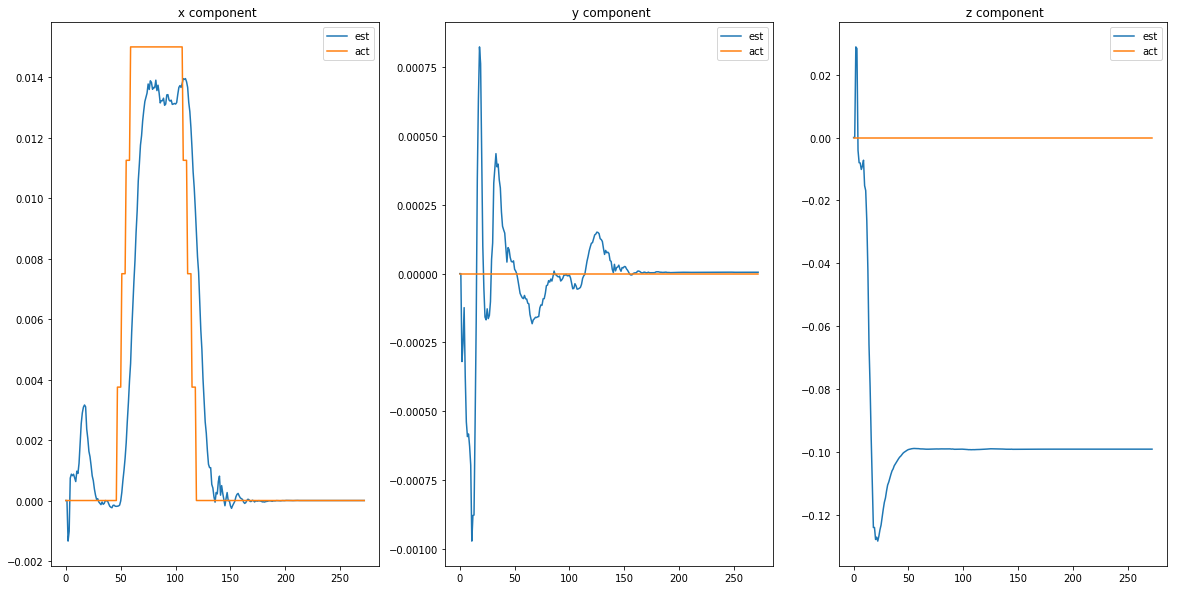

In [16]:
plot.plot_vectors(forces, processed[BOX][F_HUMAN][:, 1:], names=['est', 'act'])